In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from torch import nn, optim

In [2]:
@np.vectorize
def append_digit(str, width=2, char="0"):
    return str.rjust(width, char)

In [3]:
def get_liquidity_matrix(df, all_banks):
    a_k_nom = pd.DataFrame(0, index=all_banks, columns=all_banks, dtype=float)
    a_k_vol = pd.DataFrame(0, index=all_banks, columns=all_banks, dtype=int)
    
    for _, row in df.iterrows():
        a_k_nom.at[row["pengirim"], row["penerima"]] = row["nominal"]
        a_k_vol.at[row["pengirim"], row["penerima"]] = row["volume"]

    # a_k_vol = None
    return a_k_nom, a_k_vol

In [4]:
df = pd.concat([
    pd.read_csv("./data/2023 1.txt", delimiter=";"),
    pd.read_csv("./data/2023 2.txt", delimiter=";"),
    pd.read_csv("./data/2024.txt",   delimiter=";")
])

df["period"] = df[["tahun", "bulan", "tanggal", "jam", "menit_interval"]] \
    .apply(lambda row: "-".join(append_digit(row.values.astype(str))), axis=1)
df["period"] = pd.to_datetime(df["period"], format="%Y-%m-%d-%H-%M")

df= df[["period", "pengirim", "penerima", "nominal", "volume"]]

In [5]:
periods = df["period"].unique()
all_banks = df["pengirim"].unique()

assert set(df["pengirim"].unique()) == set(df["penerima"].unique())

In [6]:
A = []

normalized = True
transformed = False

for datetime in periods:
    a_k_nom, a_k_vol = get_liquidity_matrix(df[df["period"] == datetime], all_banks)

    a_k_vol = a_k_vol.values.flatten()
    a_k_nom = a_k_nom.values.flatten()

    if normalized:
        a_k_nom = (a_k_nom - a_k_nom.min()) / (a_k_nom.max() - a_k_nom.min())
        a_k_vol = (a_k_vol - a_k_vol.min()) / (a_k_vol.max() - a_k_vol.min())

    if transformed:
        a_k_nom = np.log1p(a_k_nom)
        a_k_vol = np.log1p(a_k_vol)
    
    A.append(np.concatenate([a_k_nom]))

A = np.array(A)

In [7]:
A = A.astype(np.float32)
A = torch.from_numpy(A)

In [8]:
del df

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim: int, encoding_dim: int):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)
        self.act_1 = nn.ReLU()
        self.act_2 = nn.Sigmoid()
    
    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x = self.act_1(x)
        x = self.decoder(x)
        # x = self.act_2(x)
        return x
    
def calculate_reconstruction_error(original, reconstructed):
    return 0.5 * torch.sum((original - reconstructed) ** 2, dim=1)

def detect_anomalies(reconstruction_errors, threshold):
    anomalies = reconstruction_errors > threshold
    return anomalies

In [10]:
model = Autoencoder(A.shape[1], 300)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
A = A.to(device)

In [12]:
X_train = A[:-300, :]
X_test = A[-300:, :]

In [13]:
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, X_train)
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/300], Loss: 0.0046
Epoch [2/300], Loss: 0.0041
Epoch [3/300], Loss: 0.0038
Epoch [4/300], Loss: 0.0036
Epoch [5/300], Loss: 0.0034
Epoch [6/300], Loss: 0.0032
Epoch [7/300], Loss: 0.0032
Epoch [8/300], Loss: 0.0031
Epoch [9/300], Loss: 0.0030
Epoch [10/300], Loss: 0.0030
Epoch [11/300], Loss: 0.0029
Epoch [12/300], Loss: 0.0029
Epoch [13/300], Loss: 0.0028
Epoch [14/300], Loss: 0.0028
Epoch [15/300], Loss: 0.0028
Epoch [16/300], Loss: 0.0028
Epoch [17/300], Loss: 0.0028
Epoch [18/300], Loss: 0.0027
Epoch [19/300], Loss: 0.0027
Epoch [20/300], Loss: 0.0027
Epoch [21/300], Loss: 0.0027
Epoch [22/300], Loss: 0.0027
Epoch [23/300], Loss: 0.0026
Epoch [24/300], Loss: 0.0026
Epoch [25/300], Loss: 0.0026
Epoch [26/300], Loss: 0.0026
Epoch [27/300], Loss: 0.0026
Epoch [28/300], Loss: 0.0026
Epoch [29/300], Loss: 0.0025
Epoch [30/300], Loss: 0.0025
Epoch [31/300], Loss: 0.0025
Epoch [32/300], Loss: 0.0025
Epoch [33/300], Loss: 0.0025
Epoch [34/300], Loss: 0.0024
Epoch [35/300], Loss: 0

In [14]:
model.eval()
with torch.no_grad():
    reconstructed_data = model(X_test)
    reconstruction_errors = calculate_reconstruction_error(X_test, reconstructed_data)

# Set a threshold for anomalies
threshold = torch.quantile(reconstruction_errors, 0.95).item()  # Example threshold
anomalies = detect_anomalies(reconstruction_errors, threshold)

# Print results
print("Number of anomalies detected:", anomalies.sum().item())

Number of anomalies detected: 15


In [15]:
# Visualization of Errors
def visualize_errors(errors, threshold):
    plt.figure(figsize=(10, 6))
    plt.plot(errors.cpu().numpy(), label='Reconstruction Error')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.title('Reconstruction Error with Anomaly Threshold')
    plt.xlabel('Sample Index')
    plt.ylabel('Reconstruction Error')
    plt.legend()
    plt.show()

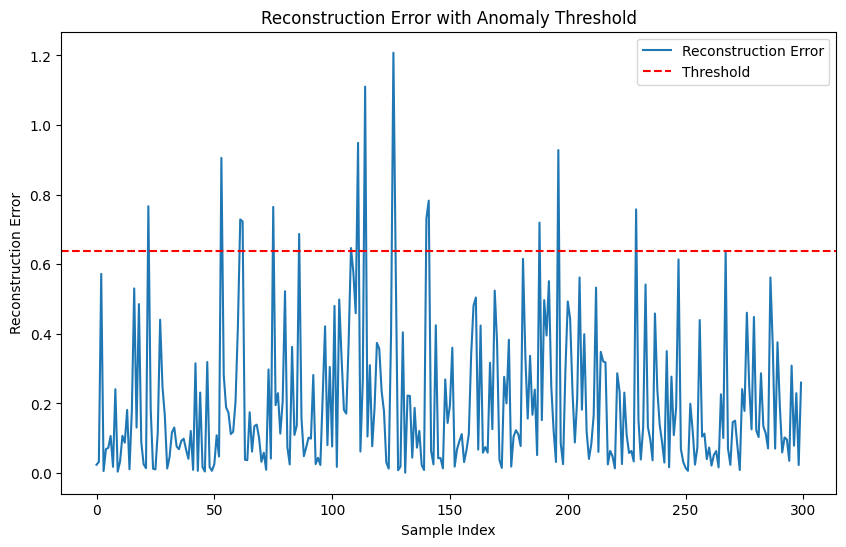

In [16]:
visualize_errors(reconstruction_errors, threshold)

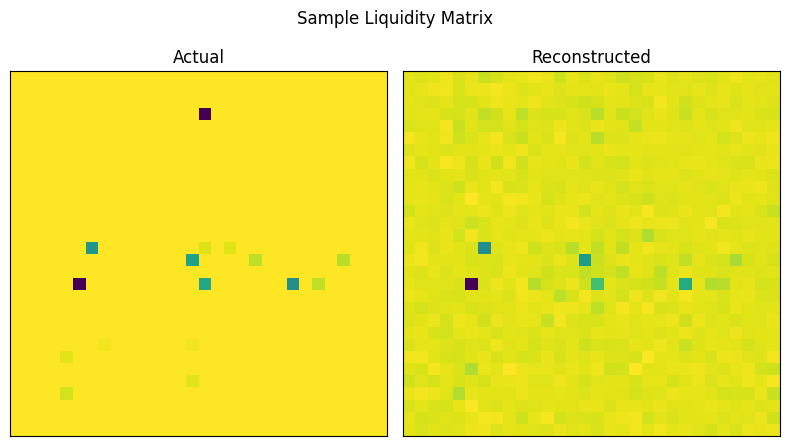

In [17]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

# Plot the first heatmap
cax1 = ax1.pcolormesh(X_test[2].reshape(30, 30).detach().cpu(), cmap='viridis_r')
ax1.set_title('Actual')
ax1.set_xticks([])
ax1.set_yticks([])

# Plot the second heatmap
cax2 = ax2.pcolormesh(model(X_test)[2].reshape(30, 30).detach().cpu(), cmap='viridis_r')
ax2.set_title('Reconstructed')
ax2.set_xticks([])
ax2.set_yticks([])

# Adjust layout to prevent overlap
plt.suptitle("Sample Liquidity Matrix")
plt.tight_layout()

# Show the plot
plt.show()  